In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [2]:
train_dir = 'Dataset/chest_xray/train'
test_dir = 'Dataset/chest_xray/test'
val_dir = 'Dataset/chest_xray/val'

In [3]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir('Dataset/chest_xray/train/PNEUMONIA')
pneumonia_dir = 'Dataset/chest_xray/train/PNEUMONIA'

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


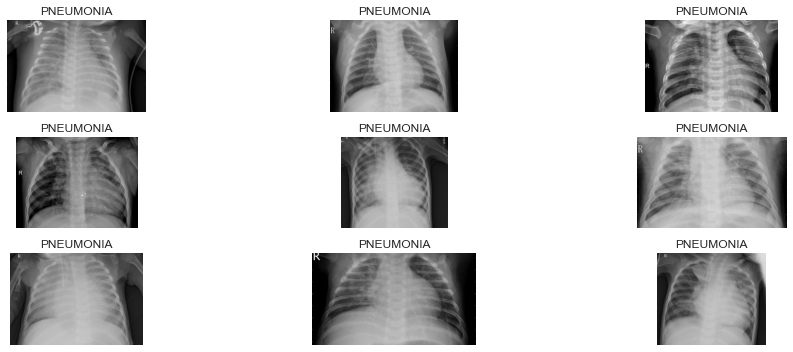

In [4]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

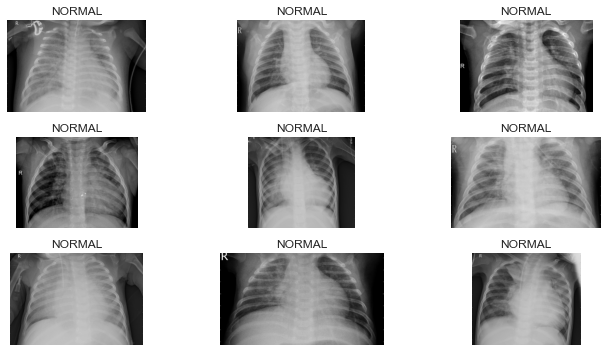

In [5]:
normal = os.listdir('Dataset/chest_xray/train/NORMAL')
normal_dir = 'Dataset/chest_xray/train/NORMAL'

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [6]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [7]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [8]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


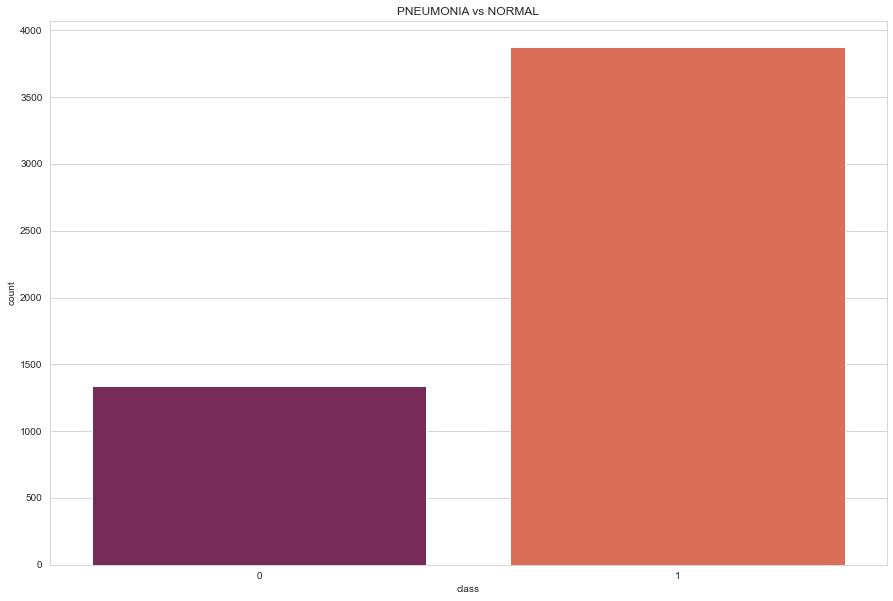

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

In [10]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [11]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')




test_set = test_datagen.flow_from_directory('Dataset/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
img, label = next(train)

In [13]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

80150528/80134624 [==============================] - 6s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [15]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 316s 3s/step - loss: 0.4871 - accuracy: 0.7641 - val_loss: 0.5040 - val_accuracy: 0.7500
Epoch 2/30
100/100 [==============================] - 315s 3s/step - loss: 0.4197 - accuracy: 0.8044 - val_loss: 0.4675 - val_accuracy: 0.7500
Epoch 3/30
100/100 [==============================] - 316s 3s/step - loss: 0.3982 - accuracy: 0.8100 - val_loss: 0.4538 - val_accuracy: 0.8125
Epoch 4/30
100/100 [==============================] - 317s 3s/step - loss: 0.3611 - accuracy: 0.8309 - val_loss: 0.4890 - val_accuracy: 0.8125
Epoch 5/30
100/100 [==============================] - 325s 3s/step - loss: 0.3321 - accuracy: 0.8544 - val_loss: 0.4087 - val_accuracy: 0.8750
Epoch 6/30
100/100 [==============================] - 1435s 14s/step - loss: 0.3226 - accuracy: 0.8591 - val_loss: 0.3905 - val_accuracy: 0.8750
Epoch 7/30
100/100 [==============================] - 318s 3s/step - loss: 0.3288 - accuracy: 0.8428 - val_loss: 0.4171 - val_accuracy: 0.87

In [16]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 542s 3s/step - loss: 0.2336 - accuracy: 0.9036
Train Loss:  0.23363453149795532
Train Accuracy:  0.9035659432411194


In [17]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 79s 252ms/step - loss: 0.3831 - accuracy: 0.8125
Test Loss:  0.3831115663051605
Test Accuracy:  0.8125


Text(0.5, 1.0, 'Accuracy Evolution')

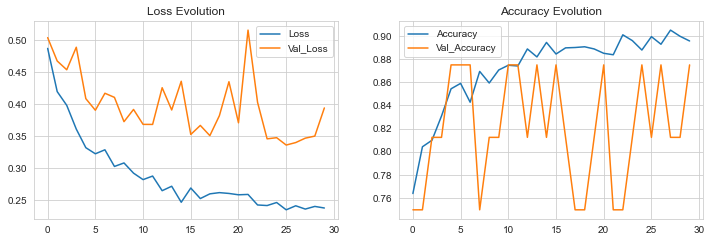

In [18]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [19]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 178s 2s/step - loss: 0.2724 - accuracy: 0.8834 - val_loss: 0.2159 - val_accuracy: 0.9375
Epoch 2/30
100/100 [==============================] - 176s 2s/step - loss: 0.2274 - accuracy: 0.9034 - val_loss: 0.2015 - val_accuracy: 0.9375
Epoch 3/30
100/100 [==============================] - 175s 2s/step - loss: 0.1827 - accuracy: 0.9303 - val_loss: 0.1976 - val_accuracy: 0.9375
Epoch 4/30
100/100 [==============================] - 172s 2s/step - loss: 0.1651 - accuracy: 0.9350 - val_loss: 0.2288 - val_accuracy: 0.9375
Epoch 5/30
100/100 [==============================] - 174s 2s/step - loss: 0.1678 - accuracy: 0.9291 - val_loss: 0.1460 - val_accuracy: 0.9375
Epoch 6/30
100/100 [==============================] - 172s 2s/step - loss: 0.1656 - accuracy: 0.9334 - val_loss: 0.2220 - val_accuracy: 0.9375
Epoch 7/30
100/100 [==============================] - 174s 2s/step - loss: 0.1628 - accuracy: 0.9362 - val_loss: 0.1771 - val_accuracy: 0.9375

In [22]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 253s 2s/step - loss: 0.1225 - accuracy: 0.9528
Train Loss:  0.12251131981611252
Train Accuracy:  0.9528374075889587
312/312 [==============================] - 44s 142ms/step - loss: 0.2029 - accuracy: 0.9167

Test loss:  0.2029268592596054
Test Accuracy:  0.9166666865348816


Text(0.5, 1.0, 'Accuracy Evolution')

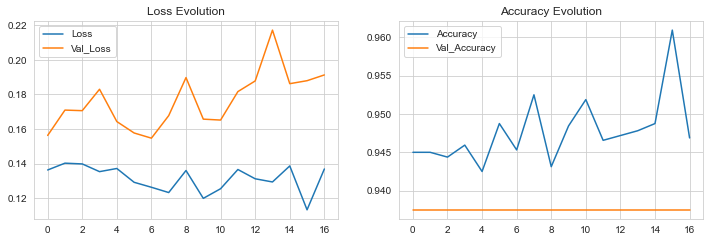

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
resnet_model.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [26]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [28]:
len(model.trainable_variables)

86

In [29]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 355s 4s/step - loss: 0.2710 - accuracy: 0.8925 - val_loss: 4.7325 - val_accuracy: 0.5000
Epoch 2/40
100/100 [==============================] - 350s 3s/step - loss: 0.1911 - accuracy: 0.9247 - val_loss: 2.5481 - val_accuracy: 0.8125
Epoch 3/40
100/100 [==============================] - 352s 4s/step - loss: 0.1569 - accuracy: 0.9375 - val_loss: 0.5125 - val_accuracy: 0.6875
Epoch 4/40
100/100 [==============================] - 349s 3s/step - loss: 0.1328 - accuracy: 0.9478 - val_loss: 0.6043 - val_accuracy: 0.6250
Epoch 5/40
100/100 [==============================] - 348s 3s/step - loss: 0.1507 - accuracy: 0.9403 - val_loss: 0.2913 - val_accuracy: 0.8125
Epoch 6/40
100/100 [==============================] - 351s 3s/step - loss: 0.1279 - accuracy: 0.9509 - val_loss: 0.1505 - val_accuracy: 0.8750
Epoch 7/40
100/100 [==============================] - 350s 3s/step - loss: 0.1340 - accuracy: 0.9525 - val_loss: 0.4496 - val_accuracy: 0.6250

In [30]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 245s 2s/step - loss: 0.0541 - accuracy: 0.9799
Train Loss:  0.05410003662109375
Train Accuracy:  0.9798696041107178
312/312 [==============================] - 44s 141ms/step - loss: 0.1512 - accuracy: 0.9439

Test loss:  0.15119031071662903
Test Accuracy:  0.9439102411270142


Text(0.5, 1.0, 'Accuracy Evolution')

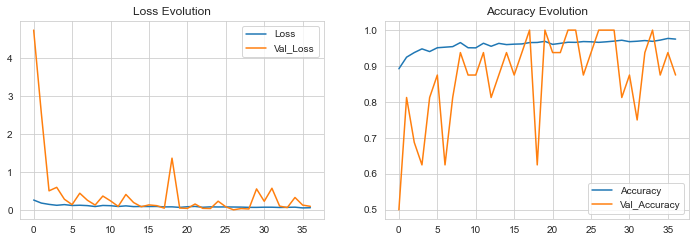

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [35]:
from keras import models
model.save('model.h5')